<center><h1>CORONA VIRUS PREDICTION<h1></center>

![CORONA VIRUS PREDICTION](corona.jpg)


In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import datetime
from datetime import date, timedelta
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


<h3>Reading Dataset<h3>

In [2]:
df = pd.read_csv('dataset.csv', index_col = 'Date')
df_india = df[df['Country/Region'] == 'India'].copy()

In [3]:
df_india.head()

,Province/State,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,,,
1/22/20,NaN,India,21.0,78.0,0,0,0
1/23/20,NaN,India,21.0,78.0,0,0,0
1/24/20,NaN,India,21.0,78.0,0,0,0
1/25/20,NaN,India,21.0,78.0,0,0,0
1/26/20,NaN,India,21.0,78.0,0,0,0


In [4]:
df_india.shape

(76, 7)

<h3>Check NULL Values<h3>

In [5]:
df_india.isna().sum()

Province/State    76
Country/Region     0
Lat                0
Long               0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

<h3>Graphical Representation of Cases in India<h3>

In [6]:
corona_cases = df_india
py.init_notebook_mode(connected=True)

data = corona_cases.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.strftime('%m/%d/%Y')
data['Active'] = data['Confirmed'] - data['Recovered'] - data['Deaths']
data['Country'] =  data['Country/Region']

fig = px.choropleth(data, locations="Country", locationmode='country names', 
                     color="Confirmed", hover_name="Country/Region",hover_data = [data.Recovered,data.Deaths,data.Active],projection="mercator",
                     animation_frame="Date",width=1000, height=700,
                     color_continuous_scale='Reds',
                     title='Map of Coronavirus')

fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig)

In [7]:
ind_map  = df_india.groupby(['Date', 'Country/Region','Lat','Long'])['Confirmed', 'Deaths', 'Recovered'].max()


ind_map = ind_map.reset_index()
ind_map.head()
ind_map['size'] = ind_map['Confirmed']*90000000
ind_map
fig = px.scatter_mapbox(ind_map, lat="Lat", lon="Long",
                     color="Confirmed", size='size',hover_data=['Confirmed','Recovered','Deaths'],
                     color_continuous_scale='burgyl',
                     animation_frame="Date", 
                     title='Spread total cases over time')
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

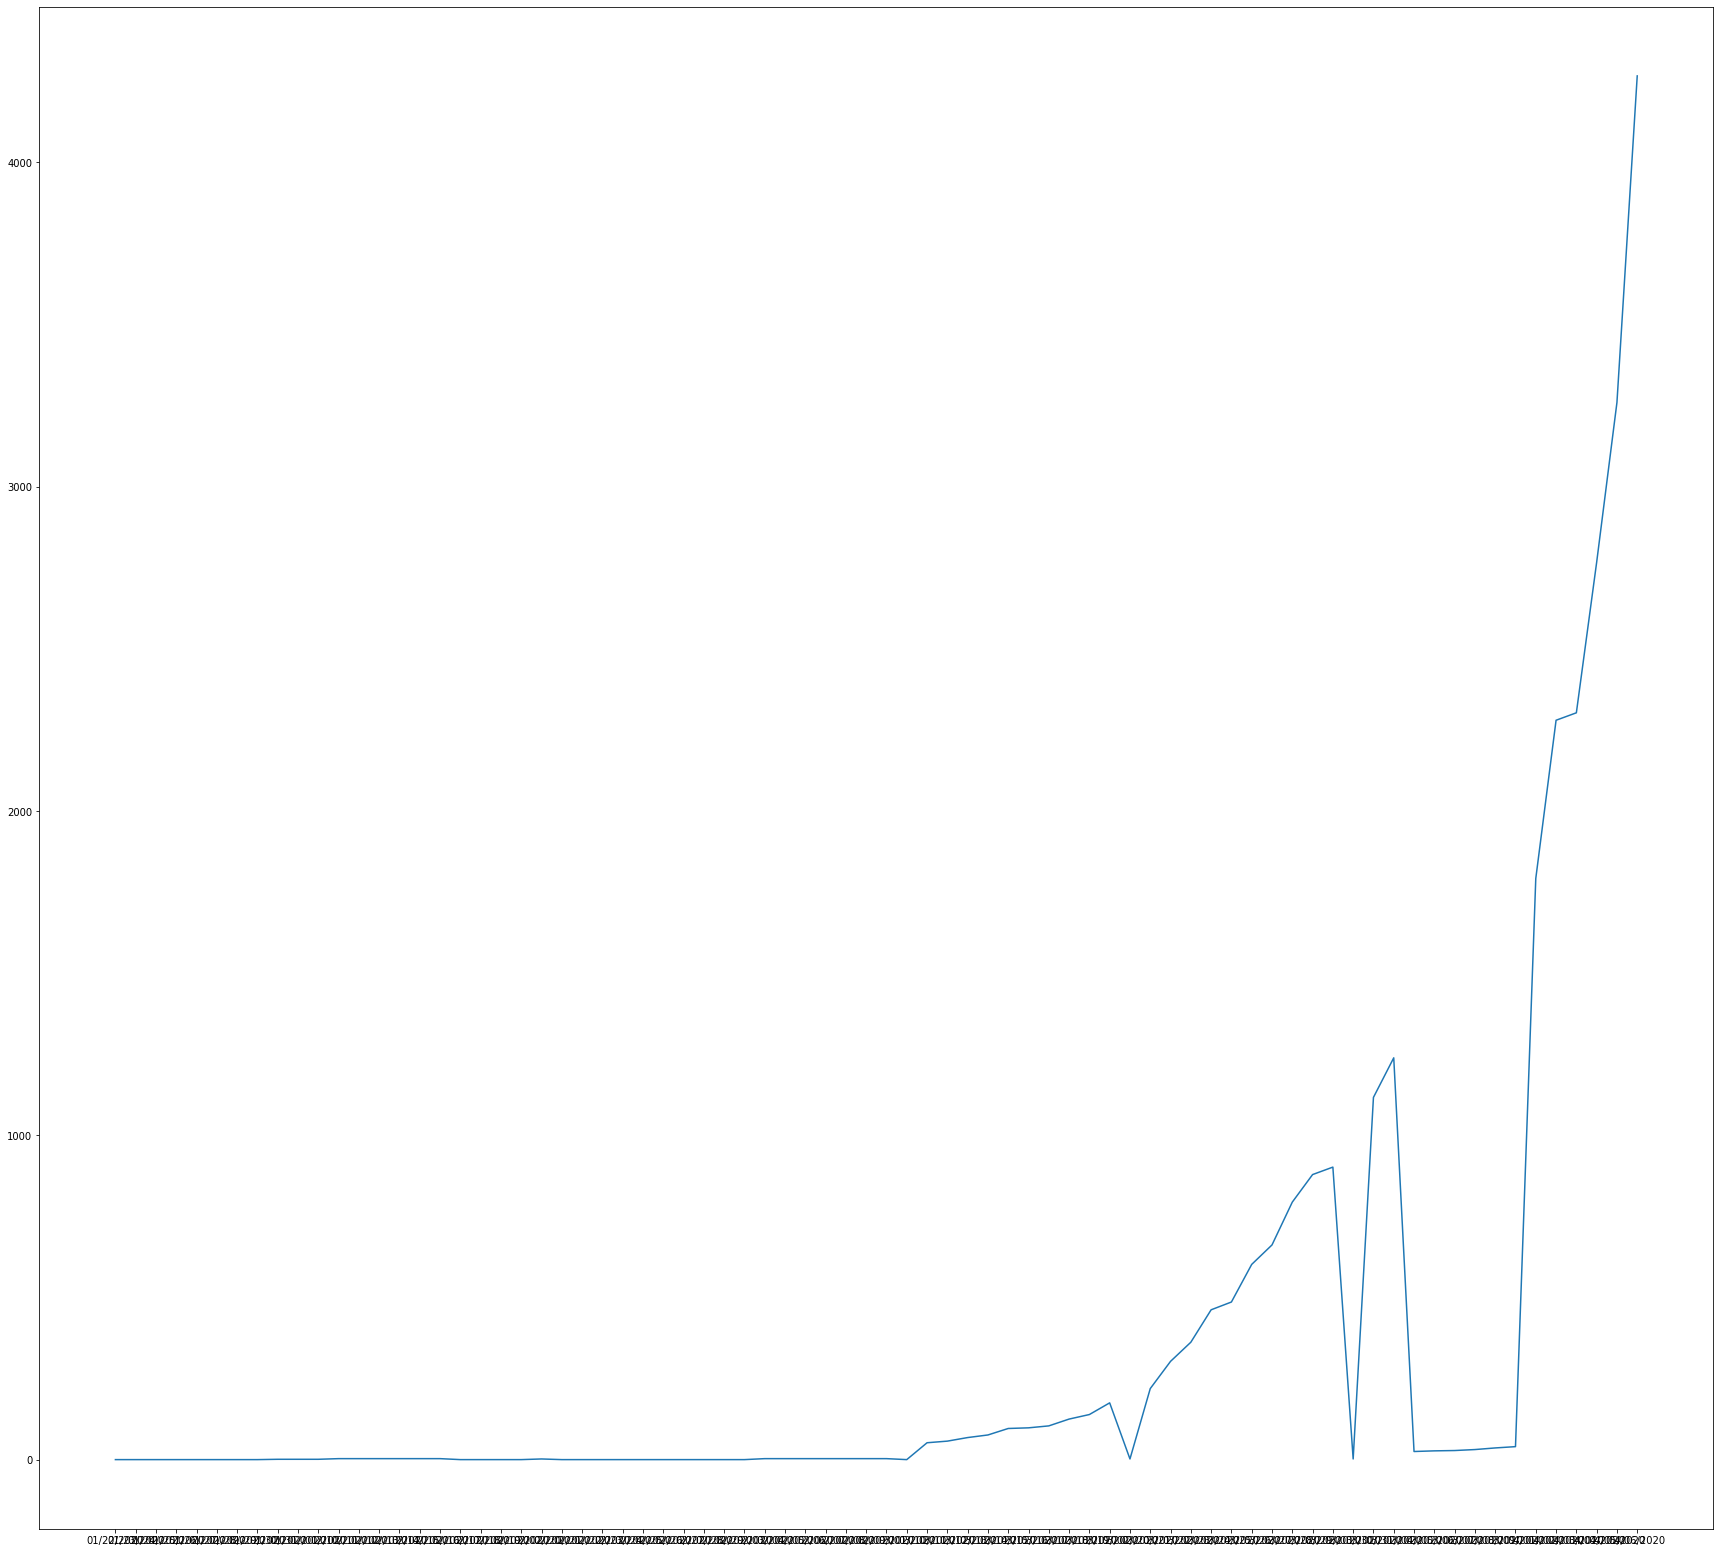

In [8]:
plt.figure(figsize = (30,28))
plt.plot(data['Date'], data['Active'])

<h3>Confirmed Cases Prediction<h3>

In [9]:
pred_cnfrm = df_india.loc[:,["Confirmed"]]

In [10]:
train_data = pred_cnfrm[:len(pred_cnfrm)-7]
test_data = pred_cnfrm[len(pred_cnfrm)-7:]

In [11]:
train_data

,Confirmed
Date,
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0
...,...
3/26/20,727
3/27/20,887
3/28/20,987


In [12]:
test_data

,Confirmed
Date,
3/31/20,1397
4/1/20,1998
4/2/20,2543
4/3/20,2567
4/4/20,3082
4/5/20,3588
4/6/20,4778


In [13]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
scaled_full_data = scaler.transform(pred_cnfrm)

In [15]:
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data,scaled_test_data, length=n_input, batch_size=1)

In [16]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 60, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(generator, epochs = 20,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/20
64/64 [==============================] - 1s 19ms/step - loss: 0.0434 - val_loss: 8.1662
Epoch 2/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 2.6234
Epoch 3/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0159
Epoch 4/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.8442
Epoch 5/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.6844


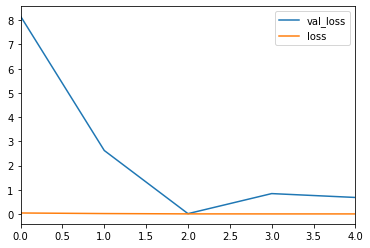

In [17]:
pd.DataFrame(lstm_model.history.history).plot()

In [18]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

confirmed_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
confirmed_prediction

,0
0,1275.943770
1,1453.256290
2,1621.726993
3,1809.450783
4,2050.335982
5,2275.812240
6,2574.053451


In [19]:
test_data

,Confirmed
Date,
3/31/20,1397
4/1/20,1998
4/2/20,2543
4/3/20,2567
4/4/20,3082
4/5/20,3588
4/6/20,4778


<h3>Deaths Predictions<h3>

In [20]:
pred_cnfrm_deaths = df_india.loc[:,["Deaths"]]

In [21]:
train_data_deaths = pred_cnfrm_deaths[:len(pred_cnfrm)-7]
test_data_deaths = pred_cnfrm_deaths[len(pred_cnfrm)-7:]

In [22]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data_deaths)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [23]:
scaled_train_data_deaths = scaler.transform(train_data_deaths)
scaled_test_data_deaths = scaler.transform(test_data_deaths)
scaled_full_data_deaths = scaler.transform(pred_cnfrm_deaths)

In [24]:
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data_deaths,scaled_train_data_deaths, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data_deaths,scaled_test_data_deaths, length=n_input, batch_size=1)

In [25]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 50, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(generator, epochs = 20,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/20
64/64 [==============================] - 1s 18ms/step - loss: 0.0388 - val_loss: 10.5170
Epoch 2/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0220 - val_loss: 3.6941
Epoch 3/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.2574
Epoch 4/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.1601
Epoch 5/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.7040
Epoch 6/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.1068
Epoch 7/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.6952
Epoch 8/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 1.7980


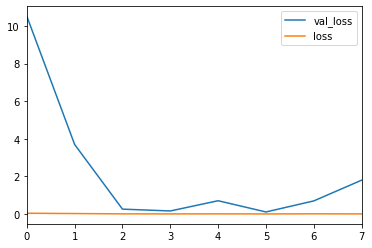

In [26]:
pd.DataFrame(lstm_model.history.history).plot()

In [27]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

deaths_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
deaths_prediction

,0
0,31.484486
1,35.385647
2,38.952339
3,42.718910
4,47.301331
5,51.229889
6,56.542721


In [28]:
test_data_deaths

,Deaths
Date,
3/31/20,35
4/1/20,58
4/2/20,72
4/3/20,72
4/4/20,86
4/5/20,99
4/6/20,136


<h3>Total Recovered Patients Predictions<h3>

In [29]:
pred_cnfrm_recovered = df_india.loc[:,["Recovered"]]

In [30]:
train_data_recovered = pred_cnfrm_recovered[:len(pred_cnfrm_recovered)-7]
test_data_recovered = pred_cnfrm_recovered[len(pred_cnfrm_recovered)-7:]

In [31]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data_recovered)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [32]:
scaled_train_data_recovered = scaler.transform(train_data_recovered)
scaled_test_data_recovered = scaler.transform(test_data_recovered)
scaled_full_data_recovered = scaler.transform(pred_cnfrm_recovered)

In [33]:
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data_recovered, scaled_train_data_recovered, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data_recovered,scaled_test_data_recovered, length=n_input, batch_size=1)

In [34]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 50, input_shape = (n_input, n_features) ))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(generator, epochs = 20,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/20
64/64 [==============================] - 1s 17ms/step - loss: 0.0426 - val_loss: 7.6601
Epoch 2/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0301 - val_loss: 4.2665
Epoch 3/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0132 - val_loss: 1.4874
Epoch 4/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.7201
Epoch 5/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0839
Epoch 6/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.3917
Epoch 7/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.3788


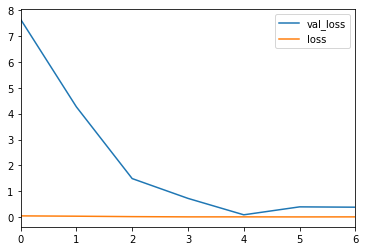

In [35]:
pd.DataFrame(lstm_model.history.history).plot()

In [36]:
lstm_predictions_scaled = []

batch = scaled_train_data_recovered[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(scaled_test_data_recovered)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

recovered_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
forecast_recovered_prediction = scaler.inverse_transform(lstm_predictions_scaled)
recovered_prediction    

,0
0,122.609012
1,154.137750
2,179.459847
3,208.881565
4,242.785473
5,282.654563
6,320.089936


In [37]:
test_data_recovered

,Recovered
Date,
3/31/20,123
4/1/20,148
4/2/20,191
4/3/20,192
4/4/20,229
4/5/20,229
4/6/20,375


<h3>Forecasting of Recovered Patients<h3>

In [38]:
forecast_index = pd.date_range(start = '4/7/20', periods = 7, freq = 'D' )

In [39]:
forecast_index

DatetimeIndex(['2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-11', '2020-04-12', '2020-04-13'],
              dtype='datetime64[ns]', freq='D')

In [40]:
forecast_df = pd.DataFrame(data = forecast_recovered_prediction, index = forecast_index, columns = ['RecoveredForecast'])

In [41]:
forecast_df

,RecoveredForecast
2020-04-07,122.609012
2020-04-08,154.137750
2020-04-09,179.459847
2020-04-10,208.881565
2020-04-11,242.785473
2020-04-12,282.654563
2020-04-13,320.089936
